In [102]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pprint import pprint

import src
from src.reload import deep_reload

In [185]:
directory = 'Outputs/Random_Experiment/'

files = os.listdir(directory)

In [186]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

cities = src.graph.graph_from_json('cities.json')

pop_adj = sum([v['population'] for k, v in cities._node.items()]) / len(cities)

weighted = {k: v['population'] / pop_adj for k, v in cities._node.items()}

unweighted = {k: 1 for k, v in cities._node.items()}

In [187]:
for k in cities.nodes:

    print(f"'{k}': lambda x: specific_impedance(x, '{k}'),")

'Crescent City': lambda x: specific_impedance(x, 'Crescent City'),
'Yreka': lambda x: specific_impedance(x, 'Yreka'),
'Redding': lambda x: specific_impedance(x, 'Redding'),
'Chico': lambda x: specific_impedance(x, 'Chico'),
'I-80 to Reno (State Line)': lambda x: specific_impedance(x, 'I-80 to Reno (State Line)'),
'Sacramento': lambda x: specific_impedance(x, 'Sacramento'),
'Stockton': lambda x: specific_impedance(x, 'Stockton'),
'San Francisco': lambda x: specific_impedance(x, 'San Francisco'),
'San Jose': lambda x: specific_impedance(x, 'San Jose'),
'Fresno': lambda x: specific_impedance(x, 'Fresno'),
'I-15 to Las Vegas (State Line)': lambda x: specific_impedance(x, 'I-15 to Las Vegas (State Line)'),
'Bakersfield': lambda x: specific_impedance(x, 'Bakersfield'),
'Los Angeles': lambda x: specific_impedance(x, 'Los Angeles'),
'I-10 to Phoenix (State Line)': lambda x: specific_impedance(x, 'I-10 to Phoenix (State Line)'),
'San Diego': lambda x: specific_impedance(x, 'San Diego'),


In [188]:
deep_reload(src)

specific_impedance = lambda x, k: src.routing.impedance(
    x[4],
    origins = {k: 1},
    destinations = weighted,
    field = 'total_time',
    constant = 1 / 3600,
)

functions = {
    'capacity': lambda x: x[1]['capacity'] / 3.6e6,
    'power': lambda x: x[1]['power'] / 1e3,
    'risk_attitude': lambda x: (x[1]['risk_attitude'][0] + x[1]['risk_attitude'][1]) / 2,
    'reliability': lambda x: x[2]['station']['reliability'],
    'graph_index': lambda x: x[0],
    'impedance_w': lambda x: src.routing.impedance(
        x[4], origins = weighted, destinations = weighted, field = 'total_time',
    ) / 3600,
    'impedance_w_r': lambda x: src.routing.impedance(
        x[4], origins = weighted, destinations = weighted, field = 'routing_time',
    ) / 3600,
    'impedance_w_d': lambda x: src.routing.impedance(
        x[4], origins = weighted, destinations = weighted, field = 'driving_time',
    ) / 3600,
    'Crescent City': lambda x: specific_impedance(x, 'Crescent City'),
    'Yreka': lambda x: specific_impedance(x, 'Yreka'),
    'Redding': lambda x: specific_impedance(x, 'Redding'),
    'Chico': lambda x: specific_impedance(x, 'Chico'),
    'I-80 to Reno (State Line)': lambda x: specific_impedance(
        x, 'I-80 to Reno (State Line)'),
    'Sacramento': lambda x: specific_impedance(x, 'Sacramento'),
    'Stockton': lambda x: specific_impedance(x, 'Stockton'),
    'San Francisco': lambda x: specific_impedance(x, 'San Francisco'),
    'San Jose': lambda x: specific_impedance(x, 'San Jose'),
    'Fresno': lambda x: specific_impedance(x, 'Fresno'),
    'I-15 to Las Vegas (State Line)': lambda x: specific_impedance(
        x, 'I-15 to Las Vegas (State Line)'),
    'Bakersfield': lambda x: specific_impedance(x, 'Bakersfield'),
    'Los Angeles': lambda x: specific_impedance(x, 'Los Angeles'),
    'I-10 to Phoenix (State Line)': lambda x: specific_impedance(
        x, 'I-10 to Phoenix (State Line)'),
    'San Diego': lambda x: specific_impedance(x, 'San Diego'),
}

In [189]:
paths = {}

outputs = {k: [] for k in functions.keys()}

idx = 0

for file in src.progress_bar.ProgressBar(files):

    idx = eval(re.findall(r'\d+', file)[0])

    if idx < 8000:

        continue

    with open(directory + file, 'rb') as f:

        out = pkl.load(f)

        paths[idx] = {'sng': out[0], 'paths': out[5]}

    for key, fun in functions.items():

        outputs[key].append(fun(out))

 [------>] (7830/7830) 100.00%, 609.11 it/s, 12.86 s elapsed, 0.00 s remaining

In [190]:
outputs_norm = outputs.copy()

keys = ['capacity', 'power', 'risk_attitude', 'reliability']

for key in keys:

    value = outputs[key]

    outputs_norm[key] = (np.array(value) - min(value)) / (max(value) - min(value))

df = pd.DataFrame(data = outputs_norm)

In [191]:
df

,capacity,power,risk_attitude,reliability,graph_index,impedance_w,impedance_w_r,impedance_w_d,Crescent City,Yreka,...,Sacramento,Stockton,San Francisco,San Jose,Fresno,I-15 to Las Vegas (State Line),Bakersfield,Los Angeles,I-10 to Phoenix (State Line),San Diego
0,0.448885,0.734843,0.764472,0.342014,1,4.335686,4.310617,4.122939,11.667378,9.666746,...,5.482194,4.892001,5.417119,5.075112,3.954883,5.315770,3.343865,2.859985,5.253610,4.270345
1,0.361544,0.757294,0.265474,0.352728,1,4.339870,4.339249,4.125433,11.507231,9.645523,...,5.434240,4.890452,5.361654,5.073487,3.974961,5.391809,3.351155,2.894282,5.236200,4.255391
2,0.825729,0.090013,0.627426,0.093699,1,4.394048,4.385963,4.120669,12.120709,10.160810,...,5.617490,4.926903,5.545806,5.109990,3.974231,5.392221,3.292585,2.862143,5.336184,4.343528
3,0.893799,0.961781,0.803717,0.330864,2,4.359354,4.310818,4.128384,11.587940,9.618907,...,5.624175,4.808223,5.552490,4.991337,3.967946,5.365284,3.290961,2.855687,5.261938,4.270726
4,0.490246,0.325106,0.819442,0.563934,2,4.504287,4.492881,4.126289,12.205516,10.140590,...,5.715313,5.222286,5.643733,5.405314,4.050117,5.610413,3.374227,2.962246,5.358767,4.429246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.791481,0.209972,0.765874,0.055812,2,4.470113,4.410520,4.128688,12.143443,10.003680,...,5.804491,4.917543,5.732806,5.100675,4.166134,5.599487,3.294639,2.890703,5.415703,4.332590
1496,0.811663,0.569549,0.800085,0.778370,0,4.271651,4.269573,4.119861,11.414424,9.603590,...,5.394889,4.796961,5.323205,4.980034,3.922137,5.248410,3.288276,2.824900,5.165696,4.218614
1497,0.157365,0.562346,0.149006,0.026411,0,4.508323,4.498185,4.125086,11.910131,9.948748,...,5.659216,5.074382,5.591902,5.260593,4.130510,5.568113,3.464777,2.992133,5.486046,4.417751
1498,0.207742,0.586434,0.993774,0.027912,2,5.754375,5.037155,4.155063,15.631374,13.009295,...,6.914943,6.383976,6.852264,6.669635,4.644999,8.263499,4.223041,3.958678,6.768983,5.344310


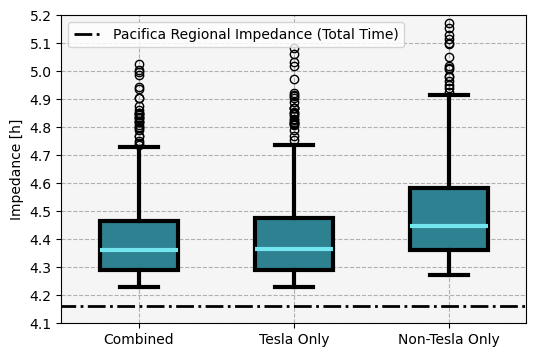

In [197]:
x = [
    df[df['graph_index'] == 0]['impedance_w'],
    df[df['graph_index'] == 1]['impedance_w'],
    df[df['graph_index'] == 2]['impedance_w'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#2e8190',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#72e5ef',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 2,
    'ls': 'dashdot',
    'label': 'Pacifica Regional Impedance (Total Time)',
}

ax.plot([-1, 4], [4.161, 4.161], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'yticks': np.arange(4, 7.25, .1),
    'xlim': (.5, 3.5),
    'ylim': (4.1, 5.2),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Impedance.png', bbox_inches = 'tight', dpi = 300)

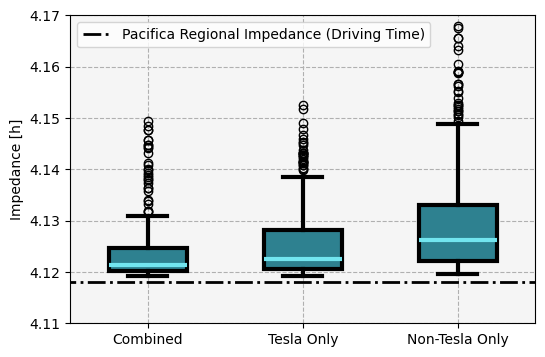

In [200]:
x = [
    df[df['graph_index'] == 0]['impedance_w_d'],
    df[df['graph_index'] == 1]['impedance_w_d'],
    df[df['graph_index'] == 2]['impedance_w_d'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#2e8190',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#72e5ef',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 2,
    'ls': 'dashdot',
    'label': 'Pacifica Regional Impedance (Driving Time)',
}

ax.plot([-1, 4], [4.118, 4.118], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    # 'yticks': np.arange(4.1, 4.3, .025),
    'xlim': (.5, 3.5),
    'ylim': (4.11, 4.17),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Impedance_Driving.png', bbox_inches = 'tight', dpi = 300)

In [201]:
cities_california = src.graph.subgraph(
    cities, [n for n in cities.nodes if '(State Line)' not in n]
)

In [202]:
pacifica_sri = np.array([10.81331175,  9.08769618,  7.56235954,  6.73363645,  5.18683418,
        4.69314255,  5.12188198,  4.88346958,  3.88588944,  3.28200579,
        2.77253372,  4.13586792])

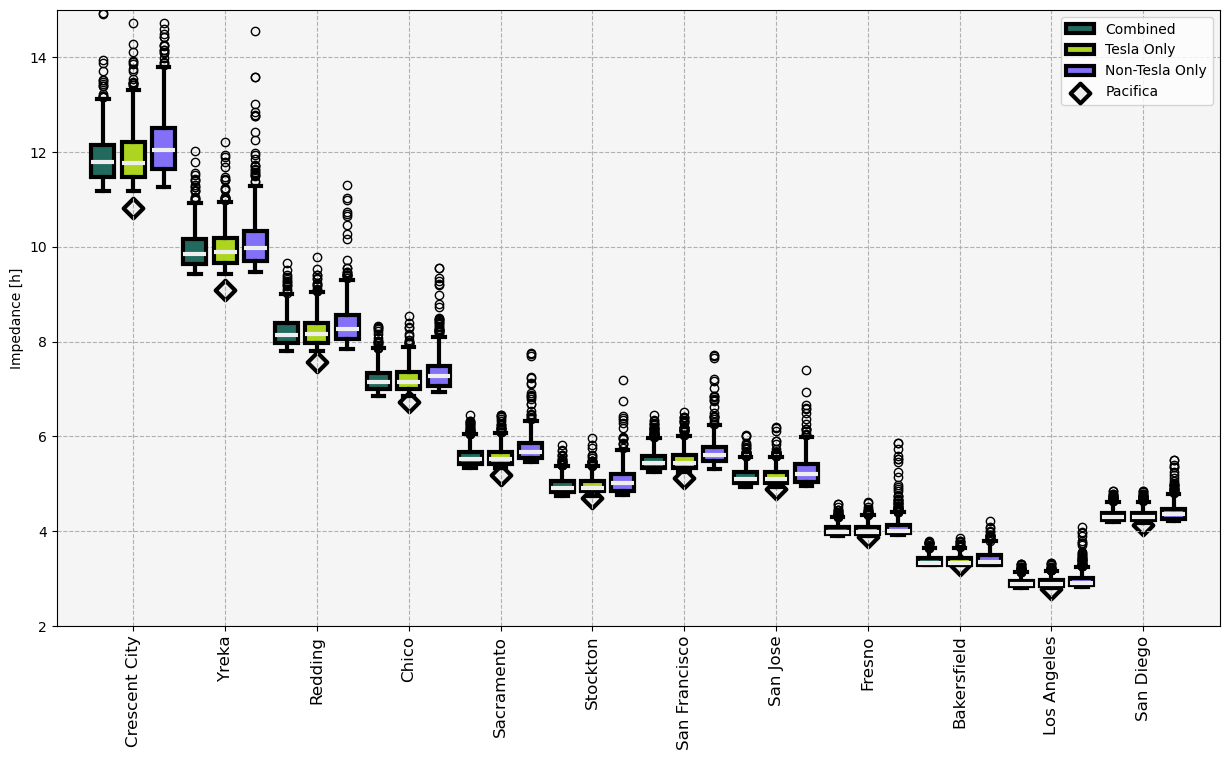

In [203]:
x0 = [df[df['graph_index'] == 0][k] for k in cities_california.nodes]
x1 = [df[df['graph_index'] == 1][k] for k in cities_california.nodes]
x2 = [df[df['graph_index'] == 2][k] for k in cities_california.nodes]

fig, ax = plt.subplots(1, 1, figsize = (15, 8))

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#22695e',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp0 = ax.boxplot(x0, positions = np.arange(0, 12, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#add51f',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp1 = ax.boxplot(x1, positions = np.arange(.33, 12.33, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#8270f6',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp2 = ax.boxplot(x2, positions = np.arange(.66, 12.66, 1), **kw)

kw = {
    'ec': 'k',
    'fc': '#eeeeee',
    'marker': 'D',
    'lw': 3,
    's': 100,
    'label': 'Pacifica',
}

sc0 = ax.scatter(np.arange(.33, 12.33, 1), pacifica_sri, **kw)

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'ylim': (2, 15),
}

_ = ax.set(**kw)

_ = ax.set_xticks(np.arange(.33, 12.33, 1))
_ = ax.set_xticklabels(list(cities_california.nodes), rotation = 90, fontsize = 12)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], sc0],
    ['Combined', 'Tesla Only', 'Non-Tesla Only', 'Pacifica'],
    loc = 'upper right',
)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Specific_Impedance_1.png', bbox_inches = 'tight', dpi = 300)

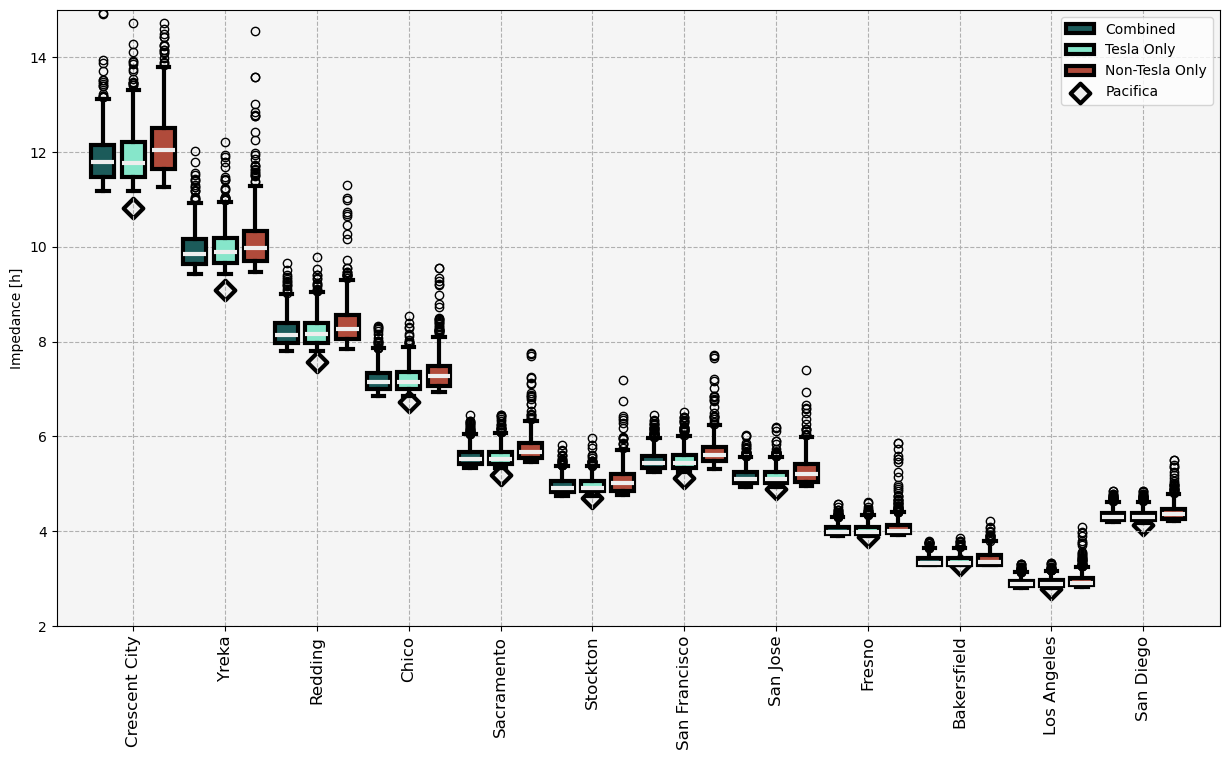

In [204]:
x0 = [df[df['graph_index'] == 0][k] for k in cities_california.nodes]
x1 = [df[df['graph_index'] == 1][k] for k in cities_california.nodes]
x2 = [df[df['graph_index'] == 2][k] for k in cities_california.nodes]

fig, ax = plt.subplots(1, 1, figsize = (15, 8))

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#1c5b5a',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp0 = ax.boxplot(x0, positions = np.arange(0, 12, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#86e6ca',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp1 = ax.boxplot(x1, positions = np.arange(.33, 12.33, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#b04b3b',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp2 = ax.boxplot(x2, positions = np.arange(.66, 12.66, 1), **kw)

kw = {
    'ec': 'k',
    'fc': '#eeeeee',
    'marker': 'D',
    'lw': 3,
    's': 100,
    'label': 'Pacifica',
}

sc0 = ax.scatter(np.arange(.33, 12.33, 1), pacifica_sri, **kw)

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'ylim': (2, 15),
}

_ = ax.set(**kw)

_ = ax.set_xticks(np.arange(.33, 12.33, 1))
_ = ax.set_xticklabels(list(cities_california.nodes), rotation = 90, fontsize = 12)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], sc0],
    ['Combined', 'Tesla Only', 'Non-Tesla Only', 'Pacifica'],
    loc = 'upper right',
)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Specific_Impedance_2.png', bbox_inches = 'tight', dpi = 300)

In [137]:
np.exp(df[(df['graph_index'] == 0)]['risk_attitude'])

3       1.914710
16      1.660115
17      1.553072
28      2.333368
30      2.231196
          ...   
1482    1.510214
1486    1.633006
1490    2.686087
1491    2.144813
1498    1.384751
Name: risk_attitude, Length: 500, dtype: float64

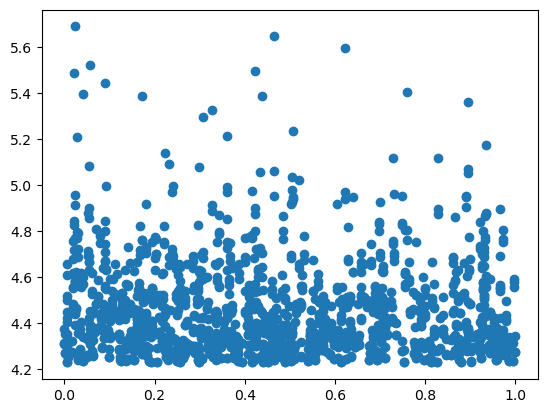

In [157]:
plt.scatter(df['reliability'], df['impedance_w'])

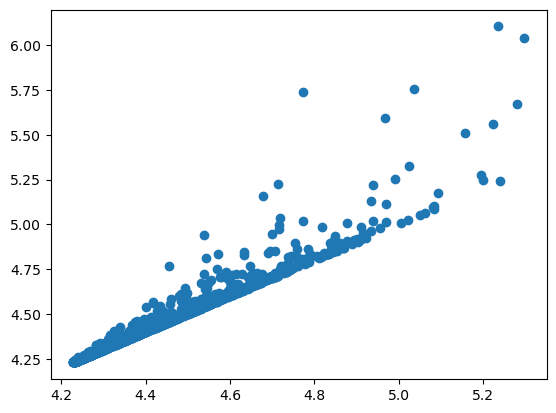

In [206]:
plt.scatter(df['impedance_w_r'], df['impedance_w'])

In [243]:
df_sel = df[(df['graph_index'] == 0)]
df_sel['risk_attitude'] = np.exp(df_sel['risk_attitude'])
# df_sel = df

formula = (
    'impedance_w ~ ' +
    # 'C(graph_index) * ' + 
    'capacity * ' + 
    'power * ' + 
    'reliability * ' +
    'risk_attitude'
)


# formula = (
#     'impedance_w ~ ' +
#     'C(graph_index) + ' + 
#     'capacity + ' + 
#     'power + ' + 
#     'reliability + ' +
#     'risk_attitude'
# )

model = smf.ols(formula, data = df_sel).fit()

In [244]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.model_anova_tabular(
    model, df_sel, 'impedance_w', 4, c = 1,
)

print(out_string)

4 16
484 15 499
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.919 & 0.845 & 0.840 & 0.000 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 11.064 & 15 & 0.738 \\
\hline Error & 2.023 & 484 & 0.004 \\
\hline Total & 13.086 & 499 & 0.026 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{176.490} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None


In [245]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string = src.analysis.significant_parameters_tabular(
    model, alpha = .05,
    label_substitutions = label_substitutions
)

print(out_string)

\hline {\small Intercept } & 4.725 & 0.000 \\
\hline {\small power } & -0.808 & 0.000 \\
\hline {\small capacity } & -0.531 & 0.000 \\
\hline {\small capacity:power } & 0.895 & 0.001 \\
\hline {\small power:reliability } & 0.549 & 0.040 \\
\hline {\small power:risk_attitude } & 0.233 & 0.008 \\
\hline {\small capacity:power:risk_attitude } & -0.386 & 0.007 \\
\hline {\small power:reliability:risk_attitude } & -0.360 & 0.014 \\
\hline {\small capacity:power:reliability:risk_attitude } & 0.532 & 0.035 \\



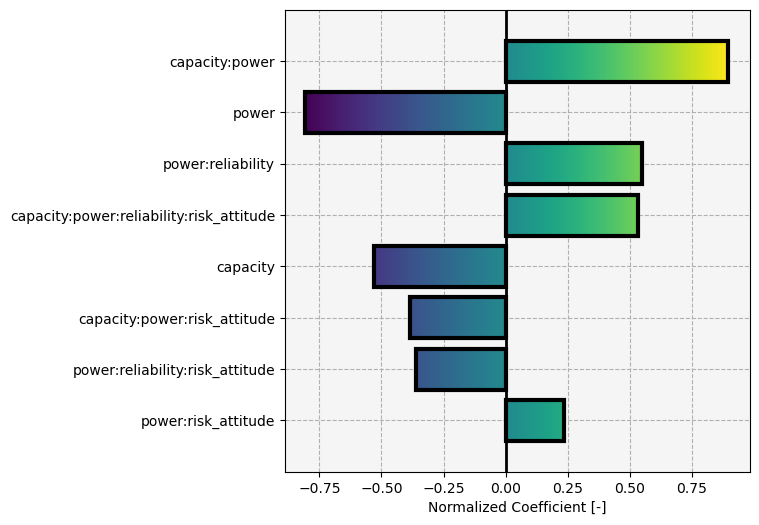

In [246]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_dict = src.analysis.significant_parameters(
    model, alpha = .05,
    label_substitutions = label_substitutions
)

out_dict.pop('Intercept')

for key, val in out_dict.items():

    val['key'] = key

out_list = np.flip(sorted(out_dict.values(), key = lambda x: np.abs(x['coefficient'])))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'ec': 'k',
    'fc': 'none',
    'lw': 3,
    'zorder': 4,
}

vmin = min([v['coefficient'] for v in out_dict.values()])
vmax = max([v['coefficient'] for v in out_dict.values()])

cmap = src.figures.colormap(["#72e5ef", "#2e8190"])
cmap = src.figures.colormap("viridis")

idx = len(out_dict) - 1

for value in out_list:

    c = value['coefficient']

    bounds = ((c - vmin) / (vmax - vmin), (0 - vmin) / (vmax - vmin))
    gradient = np.atleast_2d(np.linspace(bounds[1], bounds[0], 1000))

    bars = ax.barh(idx, width = c, **kw)
    bar = bars[0]
    
    x, y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    ax.imshow(
        gradient,
        cmap = cmap,
        extent=[x, x + w, y , y + h],
        aspect="auto",
        zorder = 3,
        vmin = 0,
        vmax = 1,
    )

    idx -= 1

kw = {
    'color': 'k',
    'lw': 2,
    'ls': '-',
    'zorder': 4,
}

ax.plot([0, 0], [-1, len(out_list)], **kw)

kw = {
    'yticks': list(range(len(out_dict))),
    'xlabel': 'Normalized Coefficient [-]',
    'yticklabels': np.flip([v['key'] for v in out_list]),
    'facecolor': 'whitesmoke',
    'ylim': (-1, len(out_list)),
    'xlim': (1.1 * vmin, 1.1 * vmax),
    # 'xticks': np.arange(-1.7, 1.1, .2),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)
# 
# fig.savefig('Paper/figs/significant_parameters.png', bbox_inches = 'tight', dpi = 300)

In [211]:
stations_used = {}

graph_index = df['graph_index'].to_numpy()

for idx, values in paths.items():

    # if values['sng'] != 0:

    #     continue

    path_collection = values['paths']

    for path_col in path_collection.values():

        for path in path_col.values():
            # print(path)

            for p in path:

                # print(p)

                if p in stations_used:

                    stations_used[p] += 1

                else:

                    stations_used[p] = 1
    #             print(p)
    #             break
    #         break
    #     break
    # break

In [212]:
len(stations_used)

310

In [213]:
graph = src.graph.graph_from_json('Outputs/sng_combined.json')
nodes = graph._node

In [214]:
nodes = graph._node

utilization = [v for k, v in stations_used.items() if 'station' in k]
ris = [nodes[k]['n_dcfc'] for k, v in stations_used.items() if 'station' in k]
ris_gen = [n['n_dcfc'] for k, n in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]
# exp_delay = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

In [215]:
un, unc = np.unique(network, return_counts = True)
indices = np.argsort(unc)

un = un[indices]
unc = unc[indices]

x = np.array(list(range(len(unc))))

In [216]:
networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
ung, ungc = np.unique(networks_general, return_counts = True)
indices = [np.argwhere(ung == n) for n in un]
indices = np.array([idx[0][0] for idx in indices])
# indices

ung = ung[indices]
ungc = ungc[indices]

xx = np.array(list(range(len(ungc))))

# x = list(range(len(unc)))

In [217]:
len(indices)

15

In [218]:
ung, un

(array(['7CHARGE', 'CHARGENET', 'EVRANGE', 'NOODOE', 'CIRCLE_K',
        'EVGATEWAY', 'RIVIAN_ADVENTURE', 'EVCS', 'SHELL_RECHARGE',
        'EV Connect', 'Non-Networked', 'eVgo Network',
        'ChargePoint Network', 'Electrify America', 'Tesla'], dtype='<U19'),
 array(['7CHARGE', 'CHARGENET', 'EVRANGE', 'NOODOE', 'CIRCLE_K',
        'EVGATEWAY', 'RIVIAN_ADVENTURE', 'EVCS', 'SHELL_RECHARGE',
        'EV Connect', 'Non-Networked', 'eVgo Network',
        'ChargePoint Network', 'Electrify America', 'Tesla'], dtype='<U19'))

In [219]:
len(x), len(xx)

(15, 15)

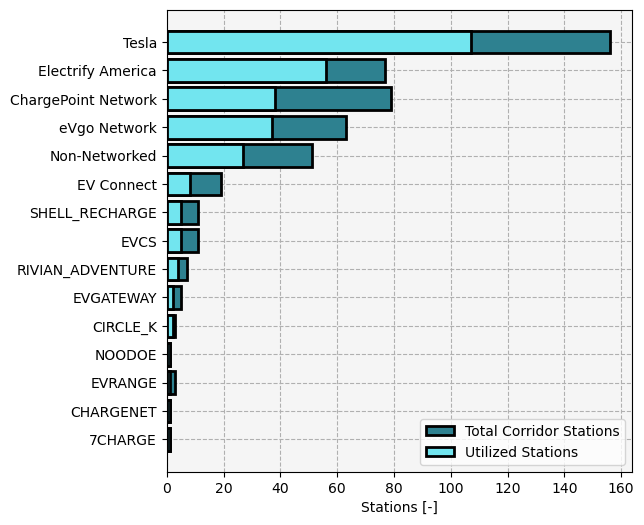

In [221]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': '#2e8190',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, ungc, **kw)


kw = {
    'color': '#72e5ef',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, unc, **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': un,
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

fig.savefig('Paper/figs/corridor_station_utilization.png', bbox_inches = 'tight', dpi = 300)

In [222]:
graph_empty = src.graph.graph_from_json('Outputs/graph_empty.json')

In [223]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [224]:
atlas = src.graph.graph_from_json('atlas.json')

In [225]:
cities = src.graph.graph_from_json('cities.json')

In [226]:
utilized = [k for k, v in stations_used.items() if 'station' in k]

sng_utilized = src.graph.subgraph(graph, utilized)

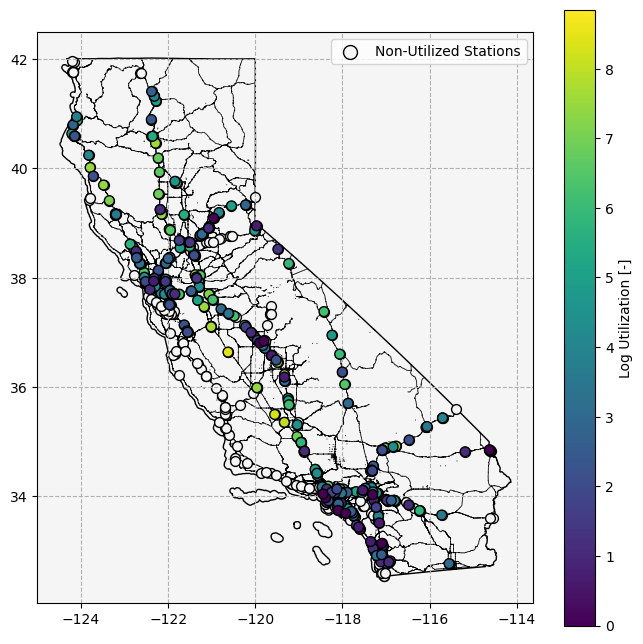

In [228]:
for source, node in sng_utilized._node.items():

    node['n_utilized'] = np.log(stations_used[source])

fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': 'whitesmoke',
        'zorder': 1,
        'label': 'Non-Utilized Stations',
    },
}

# src.figures.plot_graph(graph_empty, ax = ax, **kw)
src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'show_links': False,
    'node_field': 'n_utilized',
    'scatter': {
        's': 50,
        'ec': 'k',
        # 'fc': '#72e5ef',
        'zorder': 2,
        # 'label': 'Utilized Stations',
    },
    'colorbar': {
        'label': 'Log Utilization [-]',
        # 'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(sng_utilized, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_Utilization.png', bbox_inches = 'tight', dpi = 300)